In [2]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import SMOTE

import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [4]:
# Loading training dataset
df_train = pd.read_csv('data/data_set_ALL_AML_train.csv')

# Loading testing dataset
df_test = pd.read_csv('data/data_set_ALL_AML_independent.csv')

print(df_train.shape)
print(df_test.shape)

(7129, 78)
(7129, 70)


In [5]:
# Remove call columns in training dataset
columns_to_remove_train = [col for col in df_train if 'call' in col]
train = df_train.drop(columns_to_remove_train, axis=1)

# Remove call columns in testing dataset
columns_to_remove_test = [col for col in df_test if 'call' in col]
test = df_test.drop(columns_to_remove_test, axis=1)

In [6]:
# Transpose row and columns in training set
X_train = train.T

# Transpose row and columns in testing set
X_test = test.T

In [7]:
# Set the second row (Gene Accession Number) as the column names
X_train.columns = X_train.iloc[1]  # for training set
X_test.columns = X_test.iloc[1]  # for testing set

# Drop the first two rows (Gene Description and Gene Accession Number) and reindex
X_train = X_train.iloc[2:].reset_index(drop=True)  # for training set
X_test = X_test.iloc[2:].reset_index(drop=True)  # for testing set

print(X_train.shape)
print(X_test.shape)

(38, 7129)
(34, 7129)


In [8]:
# Convert data values to numeric for training set
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Convert data values to numeric for testing set
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [9]:
# Load labels
labels = pd.read_csv('data/actual.csv')

print(labels.shape)
labels.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [10]:
# Merge all dataset
merged_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
merged_XY = pd.concat([merged_X, labels], axis=1)

print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,ALL
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,ALL
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,ALL
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,ALL
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,ALL


In [11]:
# Check for nulls
null_counts = merged_XY.isnull().sum().max()

print('Columns with Null Values:')
print(null_counts)

Columns with Null Values:
0


In [12]:
merged_XY['cancer'].value_counts()


cancer
ALL    47
AML    25
Name: count, dtype: int64

In [13]:
# Replace values in the 'cancer' column with 0 for 'ALL' and 1 for 'AML'
cancer_mapping = {'ALL': 0, 'AML': 1}
merged_XY['cancer'] = merged_XY['cancer'].map(cancer_mapping)

In [14]:
print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


In [15]:
# Exclude patient and cancer columns
gene_columns = merged_XY.columns.drop(['patient', 'cancer'])
merged_X = merged_X[gene_columns]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data (calculate mean and standard deviation)
scaler.fit(merged_X)

# Transform the data using the fitted scaler
normalized_merged_X = scaler.transform(merged_X)

# Convert back to pandas DataFrame
normalized_merged_X = pd.DataFrame(normalized_merged_X, columns=gene_columns)

# Concatenate the normalized gene expression data with the patient and cancer columns
normalized_merged_XY = pd.concat([normalized_merged_X, merged_XY[['patient', 'cancer']]], axis=1)

In [16]:
# Create separate normalized DataFrames for ALL and AML patients
normalized_merged_XY_ALL = normalized_merged_XY[normalized_merged_XY['cancer'] == 0]
normalized_merged_XY_AML = normalized_merged_XY[normalized_merged_XY['cancer'] == 1]

print(normalized_merged_XY_ALL.shape)
print(normalized_merged_XY_AML.shape)

(47, 7131)
(25, 7131)


In [17]:
# Drop 'patient' and 'cancer' columns for each normalized_merged_XY_ALL and normalized_merged_XY_AML
normalized_merged_X_ALL = normalized_merged_XY_ALL.drop(['patient', 'cancer'], axis=1)
normalized_merged_X_AML = normalized_merged_XY_AML.drop(['patient', 'cancer'], axis=1)

In [18]:
# Perform t-test for each gene
results = []
for gene in normalized_merged_X_ALL.columns:
    t_value, p_value = ttest_ind(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene], equal_var=False)
    results.append((gene, t_value, p_value))

# Convert results list to DataFrame
df_results = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])

In [19]:
df_results.head()

,Gene Accession Number,T_Value,P_Value
0,AFFX-BioB-5_at,-1.025408,0.309136
1,AFFX-BioB-M_at,-1.379648,0.172679
2,AFFX-BioB-3_at,-1.011032,0.315506
3,AFFX-BioC-5_at,-2.422568,0.018676
4,AFFX-BioC-3_at,0.029392,0.976665


In [20]:
# Set the threshold for significance level
threshold = 0.05

# Get the list of significant genes based on the threshold
significant_genes = df_results[rejected & (adjusted_p_values < threshold)]

# Sort significant genes based on p-values
significant_genes = significant_genes.sort_values(by='P_Value')

# Add rank to significant genes DataFrame
significant_genes['Rank'] = significant_genes['P_Value'].rank()

# Display the results
print("Total Genes: 7129")
print("Significant Genes (T-test):", len(significant_genes))

Total Genes: 7129
Significant Genes (T-test): 34


In [21]:
significant_genes_Acc = significant_genes['Gene Accession Number']

# Extracting gene expression data
significant_genes_data_all = normalized_merged_XY_ALL[significant_genes_Acc]
significant_genes_data_aml = normalized_merged_XY_AML[significant_genes_Acc]

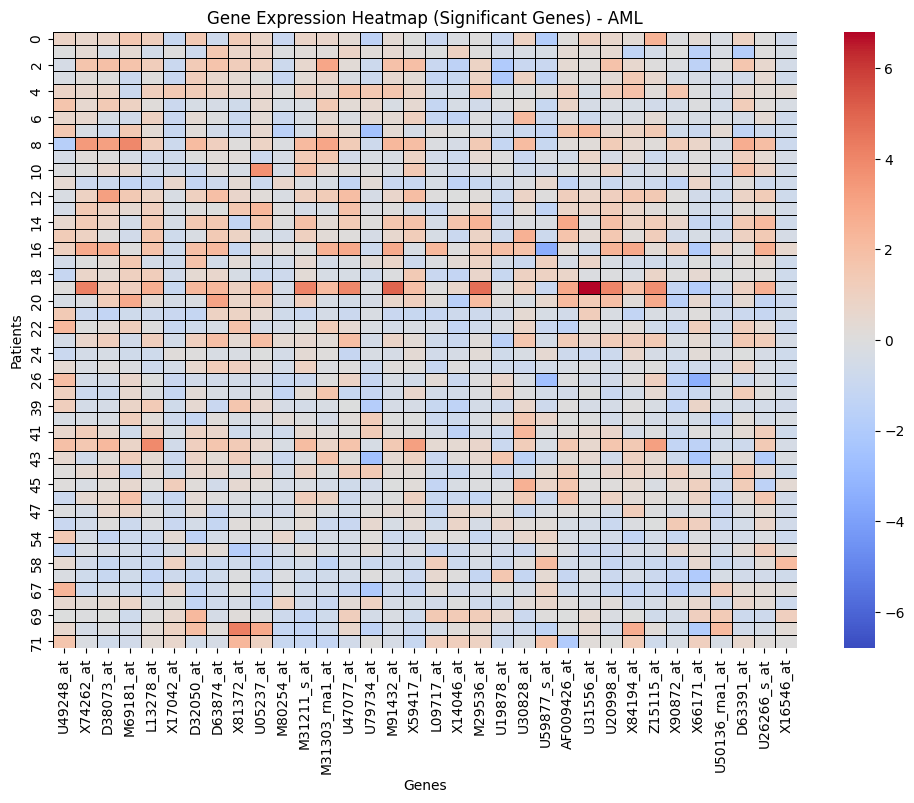

In [22]:
# For the comparison, use the same maximum absolute expression value for ALL and AML patients
max_abs_value_all = max(abs(significant_genes_data_all.values.max()), abs(significant_genes_data_all.values.min()))

# Generate heatmap for AML patients
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_all, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - AML')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

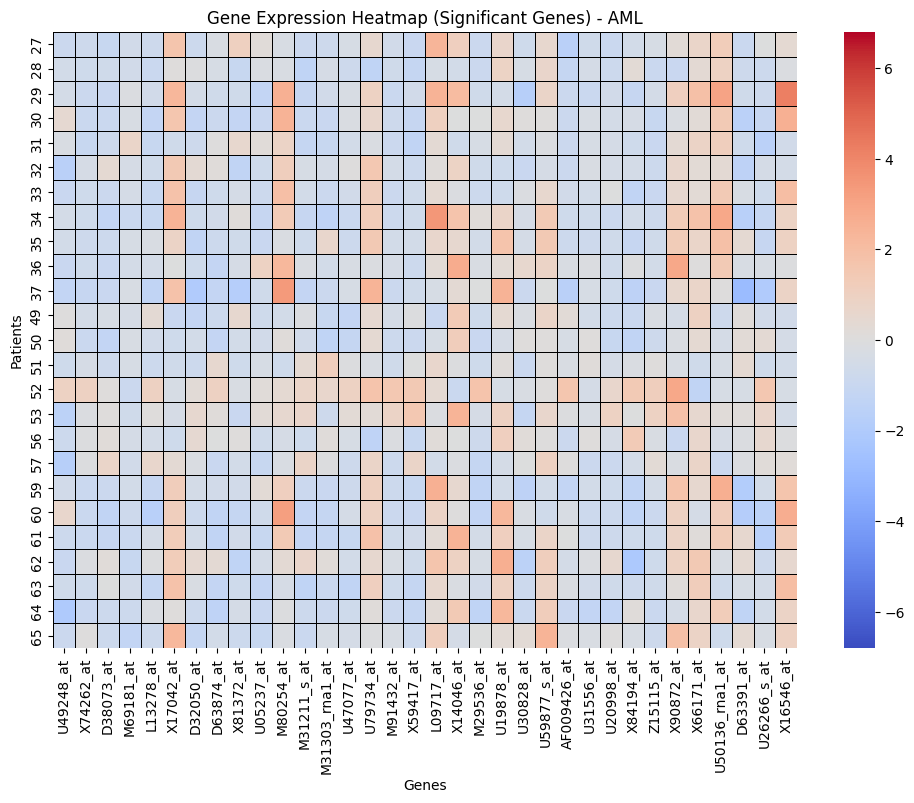

In [23]:
max_abs_value_aml = max(abs(significant_genes_data_all.values.max()), abs(significant_genes_data_all.values.min()))

# Generate heatmap for AML patients
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_aml, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - AML')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

In [24]:
significant_genes.drop(['T_Value', 'P_Value'], axis=1, inplace=True)
significant_genes.head(3)

,Gene Accession Number,Rank
3300,U49248_at,1.0
4534,X74262_at,2.0
5253,D38073_at,3.0


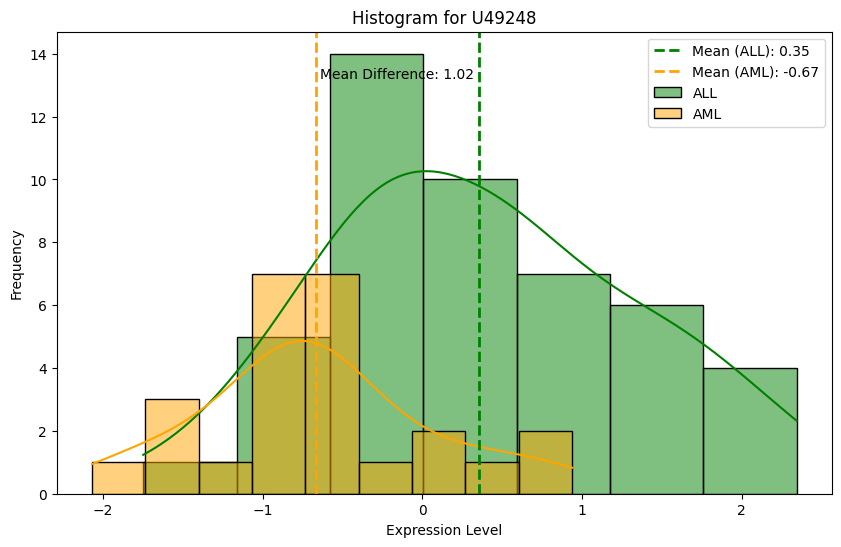

In [29]:
# Select gene expression data for both cancer types
gene_selected = 'U49248_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

# Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

# Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

# Plot histogram for both cancer types
plt.figure(figsize=(10, 6))

# Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='green', label='ALL', kde=True)

# Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='orange', label='AML', kde=True)

# Annotate mean values
plt.axvline(mean_expression_all, color='green', linestyle='dashed', linewidth=2, label=f'Mean (ALL): {mean_expression_all:.2f}')
plt.axvline(mean_expression_aml, color='orange', linestyle='dashed', linewidth=2, label=f'Mean (AML): {mean_expression_aml:.2f}')

# Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml) / 2, plt.gca().get_ylim()[1]*0.9, f'Mean Difference: {mean_difference:.2f}', ha='center')

# Set labels and title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for U49248')

# Add legend
plt.legend()

# Show plot
plt.show()

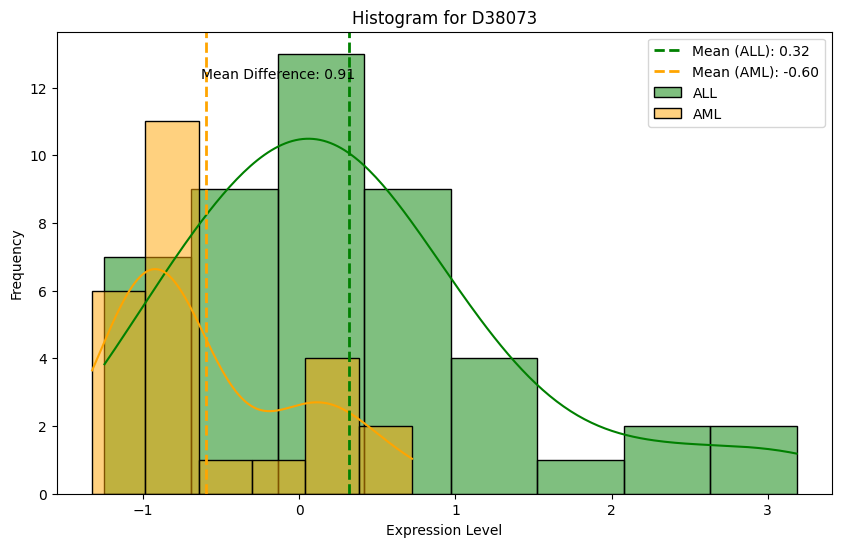

In [32]:
# Select gene expression data for both cancer types
gene_selected = 'D38073_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

# Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

# Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

# Plot histogram for both cancer types
plt.figure(figsize=(10, 6))

# Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='green', label='ALL', kde=True)

# Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='orange', label='AML', kde=True)

# Annotate mean values
plt.axvline(mean_expression_all, color='green', linestyle='dashed', linewidth=2, label=f'Mean (ALL): {mean_expression_all:.2f}')
plt.axvline(mean_expression_aml, color='orange', linestyle='dashed', linewidth=2, label=f'Mean (AML): {mean_expression_aml:.2f}')

# Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml) / 2, plt.gca().get_ylim()[1]*0.9, f'Mean Difference: {mean_difference:.2f}', ha='center')

# Set labels and title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for D38073')

# Add legend
plt.legend()

In [33]:
# Select top n genes
top_n_genes = significant_genes.head(3)['Gene Accession Number']

# Select data for the top 50 genes from normalized_merged_XY
top_n_data = normalized_merged_XY[top_n_genes]

print(top_n_data.shape)
# Splitting the data into train and test sets
train_size = 38
normalized_X_train = top_n_data.iloc[:train_size, :]
normalized_X_test = top_n_data.iloc[train_size:, :]

# Check the shapes of the train and test sets
print("Train set shape:", normalized_X_train.shape)
print("Test set shape:", normalized_X_test.shape)

# Split target labels for training and testing
cancer_target = labels.iloc[:,1]
y_train = cancer_target[:38]  # Target labels for training
y_test = cancer_target[38:]  # Target labels for testing

(72, 3)
Train set shape: (38, 3)
Test set shape: (34, 3)


In [34]:
print("Before Upsampling:-")
print(Counter(y_train))

# Use SMOTE to oversample
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(normalized_X_train,y_train)

print("After Upsampling:-")
print(Counter(y_train_ov))

Before Upsampling:-
Counter({'ALL': 27, 'AML': 11})
After Upsampling:-
Counter({'ALL': 27, 'AML': 27})


Best Parameters:
 {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'linear'}
SVM accuracy: 0.824
True Positive Rate (Recall) for AML class: 0.786
True Negative Rate (Specificity) for ALL class: 0.85


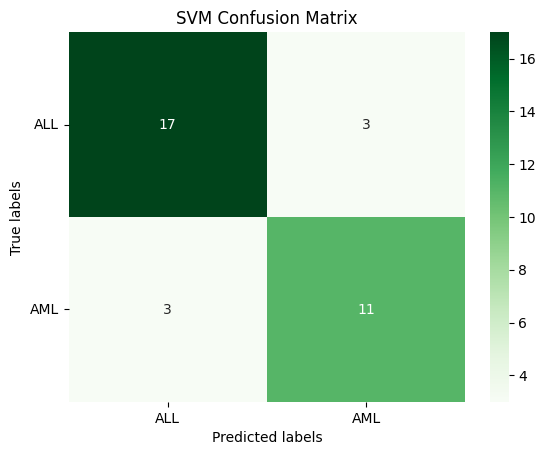

In [35]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10],
    "kernel": ["linear", "rbf", "poly"],
    "decision_function_shape": ["ovo", "ovr"]
} 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_ov, y_train_ov)

# Print the best parameters found by the grid search
print("Best Parameters:\n", svm_grid.best_params_)

# Select the best SVC model
best_svc = svm_grid.best_estimator_

# Make predictions using the optimized parameters
svm_pred = best_svc.predict(normalized_X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', round(accuracy, 3))

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred)

# Extract true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) from confusion matrix
TN, FP, FN, TP = cm_svm.ravel()

# Calculate True Positive Rate (Recall) for AML class
TPR_aml = TP / (TP + FN)

# Calculate True Negative Rate (Specificity) for ALL class
TNR_all = TN / (TN + FP)

print('True Positive Rate (Recall) for AML class:', round(TPR_aml, 3))
print('True Negative Rate (Specificity) for ALL class:', round(TNR_all, 3))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax=ax, fmt='g', cmap='Greens') 

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('SVM Confusion Matrix') 
ax.xaxis.set_ticklabels(['ALL', 'AML']) 
ax.yaxis.set_ticklabels(['ALL', 'AML'], rotation=360);
